In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2

import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/train/'
test_dir = 'data/test/'

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.1.6
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
output_classes = 7
batch_size = 8

img_height, img_width = 600, 450
input_shape = (img_height, img_width, 3)
epochs = 50

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/train/ 0
data/train/AKIEC 34704
data/train/BCC 19092
data/train/BKL 13100
data/train/DF 16608
data/train/MEL 13232
data/train/NV 19900
data/train/VASC 6976
******************************
data/test/ 0
data/test/AKIEC 74
data/test/BCC 139
data/test/BKL 284
data/test/DF 30
data/test/MEL 312
data/test/NV 1730
data/test/VASC 33


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 92709 images belonging to 7 classes.
Found 30903 images belonging to 7 classes.
Found 2602 images belonging to 7 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 92709
nb_validation_samples: 30903

predict_size_train: 11589
predict_size_validation: 3863
nb_test_samples: 2602
predict_size_test: 326

 num_classes: 7


In [9]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [10]:
model = Sequential()
# Conv Layer 1
model.add(layers.SeparableConv2D(32, (9, 9), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(2, 2))
# model.add(layers.Dropout(0.25))

# Conv Layer 2
model.add(layers.SeparableConv2D(64, (9, 9), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
# model.add(layers.Dropout(0.25))

# Conv Layer 3
model.add(layers.SeparableConv2D(128, (9, 9), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
# model.add(layers.Dropout(0.25))

# model.add(layers.SeparableConv2D(256, (9, 9), activation='relu'))
# model.add(layers.MaxPooling2D(2, 2))
# Flatten the data for upcoming dense layer
model.add(layers.Flatten())

model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(output_classes, activation=tf.nn.softmax))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 592, 442, 32)      371       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 296, 221, 32)      0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 288, 213, 64)      4704      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 144, 106, 64)      0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 136, 98, 128)      13504     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 68, 49, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 426496)            0         
__________

In [11]:
# adam_opt = Adam(lr=0.0001, decay=1e-5)
adam_opt=Adam(lr=0.0001, beta_1=0.6, beta_2=0.995, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer= adam_opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size)

Epoch 1/50
11588/11588 [==============================] - 6414s 553ms/step - loss: 1.4990 - acc: 0.4187 - val_loss: 1.1983 - val_acc: 0.5282
Epoch 2/50
11588/11588 [==============================] - 6405s 553ms/step - loss: 1.1494 - acc: 0.5595 - val_loss: 1.0015 - val_acc: 0.6111
Epoch 3/50
11588/11588 [==============================] - 6407s 553ms/step - loss: 0.9610 - acc: 0.6447 - val_loss: 0.7501 - val_acc: 0.7348
Epoch 4/50
11588/11588 [==============================] - 6401s 552ms/step - loss: 0.7862 - acc: 0.7151 - val_loss: 0.6719 - val_acc: 0.7447
Epoch 5/50
11588/11588 [==============================] - 6417s 554ms/step - loss: 0.6367 - acc: 0.7720 - val_loss: 0.4823 - val_acc: 0.8302
Epoch 6/50
11588/11588 [==============================] - 6404s 553ms/step - loss: 0.5189 - acc: 0.8146 - val_loss: 0.3900 - val_acc: 0.8642
Epoch 7/50
11588/11588 [==============================] - 6406s 553ms/step - loss: 0.4346 - acc: 0.8458 - val_loss: 0.3550 - val_acc: 0.8752
Epoch 8/50
11

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\prepr

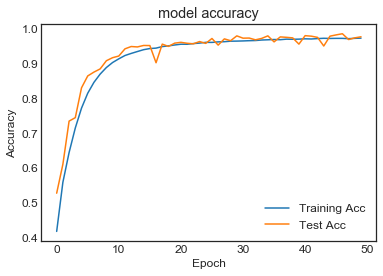

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


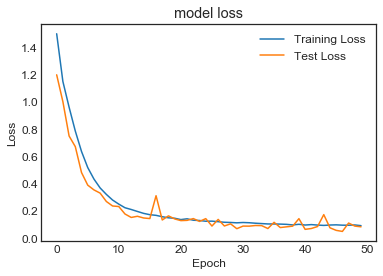

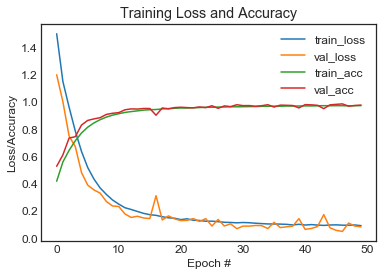

In [13]:
plt.rcParams.update({'font.size': 12})

import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='bottom right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper right')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

In [14]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

Validation Score:  9.841183123569408e-05
Validation Accuracy:  1.0


C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

In [15]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=2)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:799: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\User\Anaconda\Anaconda3\lib\site-packages\keras\preprocessing\image.py:807: UserWarning: Thi

No of errors = 444/2602


Confusion Matrix
[[  69    3    1    0    1    0    0]
 [   4  133    0    0    0    2    0]
 [   4    4  255    0   11   10    0]
 [   0    0    0   28    0    2    0]
 [   7    5   15    1  266   17    1]
 [  26   49  115    8  153 1375    4]
 [   0    0    0    0    0    1   32]]


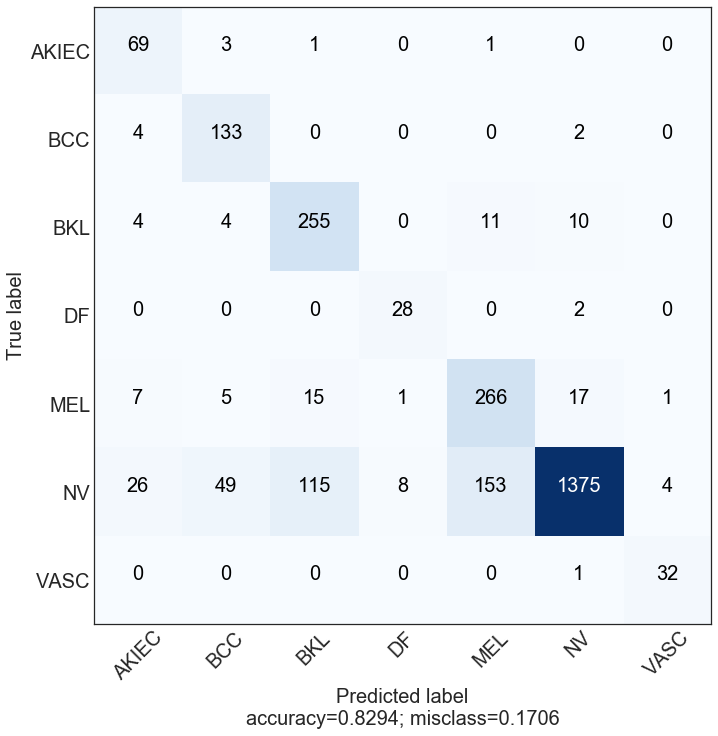

In [16]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels, title='Confusion Matrix')

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname) 

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[  69    3    1    0    1    0    0]
 [   4  133    0    0    0    2    0]
 [   4    4  255    0   11   10    0]
 [   0    0    0   28    0    2    0]
 [   7    5   15    1  266   17    1]
 [  26   49  115    8  153 1375    4]
 [   0    0    0    0    0    1   32]]
             precision    recall  f1-score   support

      AKIEC       0.63      0.93      0.75        74
        BCC       0.69      0.96      0.80       139
        BKL       0.66      0.90      0.76       284
         DF       0.76      0.93      0.84        30
        MEL       0.62      0.85      0.72       312
         NV       0.98      0.79      0.88      1730
       VASC       0.86      0.97      0.91        33

avg / total       0.87      0.83      0.84      2602



In [18]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  0.9452054794520548
Specificity :  0.9779411764705882


In [19]:
for i in range(len(errors)):
    pred_class = np.argmax(predicts[errors[i]])
    pred_label = indexlabel[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}, class ID : {}'.format(
        filename[errors[i]].split('/')[0],
        pred_label,
        predicts[errors[i]][pred_class], pred_class)
    print(filename[errors[i]])  

AKIEC\ISIC_0026100.jpg
AKIEC\ISIC_0027303.jpg
AKIEC\ISIC_0028820.jpg
AKIEC\ISIC_0031043.jpg
AKIEC\ISIC_0031738.jpg
BCC\ISIC_0026453.jpg
BCC\ISIC_0026656.jpg
BCC\ISIC_0028670.jpg
BCC\ISIC_0028688.jpg
BCC\ISIC_0029545.jpg
BCC\ISIC_0031009.jpg
BKL\ISIC_0024471.jpg
BKL\ISIC_0024782.jpg
BKL\ISIC_0025366.jpg
BKL\ISIC_0025548.jpg
BKL\ISIC_0025805.jpg
BKL\ISIC_0026553.jpg
BKL\ISIC_0026895.jpg
BKL\ISIC_0027027.jpg
BKL\ISIC_0027192.jpg
BKL\ISIC_0028309.jpg
BKL\ISIC_0028404.jpg
BKL\ISIC_0028611.jpg
BKL\ISIC_0028913.jpg
BKL\ISIC_0029113.jpg
BKL\ISIC_0029345.jpg
BKL\ISIC_0029683.jpg
BKL\ISIC_0029872.jpg
BKL\ISIC_0030007.jpg
BKL\ISIC_0030768.jpg
BKL\ISIC_0031088.jpg
BKL\ISIC_0031519.jpg
BKL\ISIC_0032111.jpg
BKL\ISIC_0032200.jpg
BKL\ISIC_0032481.jpg
BKL\ISIC_0033041.jpg
BKL\ISIC_0033507.jpg
BKL\ISIC_0033606.jpg
BKL\ISIC_0033613.jpg
BKL\ISIC_0033744.jpg
DF\ISIC_0024330.jpg
DF\ISIC_0031123.jpg
MEL\ISIC_0024767.jpg
MEL\ISIC_0024886.jpg
MEL\ISIC_0024918.jpg
MEL\ISIC_0024972.jpg
MEL\ISIC_0025128.jpg
MEL\I

In [20]:
model.save('saved_models/4conv_3_3.h5')
model.save_weights('saved_models/4conv_3_3_Weights.h5')

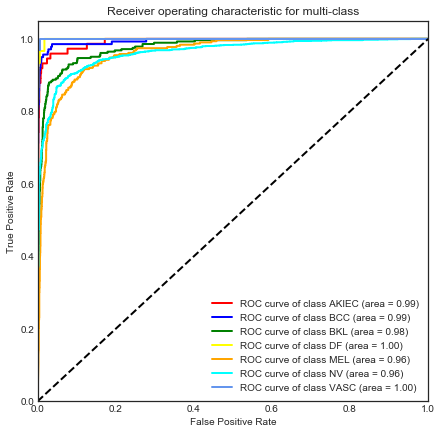

In [21]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle




y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4,5,6])
y_pred_binary = y_pred_probabilities#label_binarize(y_pred_probabilities, classes=[0, 1, 2, 3, 4])
n_classes=7
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

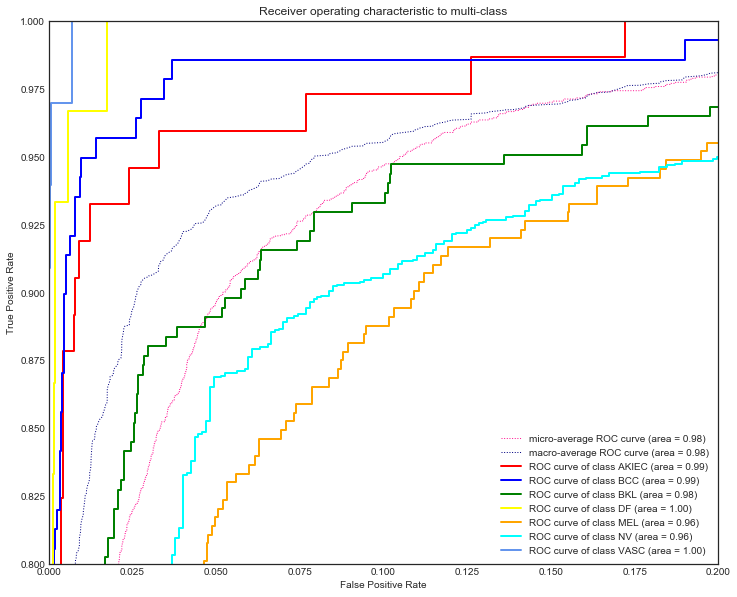

In [23]:
# Zoom in view of the upper left corner.
plt.figure(figsize=(12,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)


plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=1)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=1)

colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")

plt.show()